<a href="https://colab.research.google.com/github/tuananh11052000/CS114.K21/blob/master/detect_homan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kết nối với google driver để truy xuất dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import các thư viện cần thiết để sử dụng cho các shell tiếp theo

In [2]:
import glob
import cv2
import numpy as np
import os
import random
import skimage
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Định nghĩa hàm HOG rút trích đặc trưng sử dụng trọng số truyền vào

In [45]:
class HOG:
    def __init__(self, orientations=12, pixelsPerCell=(2, 2), cellsPerBlock=(2, 2), normalize=True):
        # store the number of orientations, pixels per cell, cells per block, and
        # whether normalization should be applied to the image
        self.orientations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.normalize = normalize

    def describe(self, image):
        # compute Histogram of Oriented Gradients features for scikit-image < 0.13
        if int(skimage.__version__.split(".")[1]) < 13:
            
            hist = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixelsPerCell,
                               cells_per_block=self.cellsPerBlock, transform_sqrt=self.normalize)

        # otherwise comput Histogram of Oriented Gradients features for scikit-image >= 0.13
        else:
            hist = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixelsPerCell,
                               cells_per_block=self.cellsPerBlock, transform_sqrt=self.normalize, block_norm="L1")

        hist[hist < 0] = 0

        # return the histogram
        return hist



*   Đọc dữ liệu từ google driver
*   Đọc ảnh và gán nhãn



In [48]:
datasetPaths = []
labels = []
data = []
for linkimage in glob.iglob('/content/drive/My Drive/Colab Notebooks/CUOI_KY/*/*.png', recursive=True):
    datasetPaths.append(linkimage);
random.shuffle(datasetPaths)
for path in datasetPaths:
  labels.append(path.split(os.path.sep)[-2])
  data.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

*   Chuyển nhãn về dạng số để phù hợp cho việc train model
*   Trong bước này, ảnh có người có nhãn là 1
*   Ảnh không người có nhãn là 0

In [49]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
le.classes_
lb = le.transform(labels)

**Sử dụng HOG để rút trích đặc trưng**




In [51]:
features = []
hog = HOG(orientations=12, pixelsPerCell=(4, 4), cellsPerBlock=(2, 2), normalize=True)
for img in data:
  features.append(hog.describe(img))

Chia bộ train test theo tỷ lệ 75-25

In [52]:
x_train, x_test, y_train, y_test = train_test_split(features, lb, test_size=0.1)

Sử dụng SVM để train trên bộ feature đã thu được ở trên

In [53]:
model = SVC(kernel="linear", probability=False, random_state=42)
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [54]:
from sklearn.metrics import accuracy_score
pred = model.predict(x_test)
print('acc: ', accuracy_score(pred, y_test))

acc:  0.975975975975976


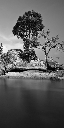

[0]


In [62]:
img = cv2.imread("4.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 128))
cv2_imshow(img)
temp = hog.describe(img)
pred = model.predict([temp])
print(pred)

# Sử dụng KNN


In [38]:
from sklearn import neighbors, datasets
clf = neighbors.KNeighborsClassifier(n_neighbors = 5, p = 1)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [39]:
pred = clf.predict(x_test)
print('acc: ', accuracy_score(pred, y_test))

acc:  0.28725961538461536
